In [1]:
!pip install pandas_datareader

In [2]:
#Import the libraries
import math
import numpy as np
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import pickle
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
df = web.DataReader('TSLA', data_source='yahoo', start='2012-01-01', end='2020-06-30') 
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,5.900,5.530,5.788,5.616,4640500,5.616
2012-01-04,5.734,5.500,5.642,5.542,3150500,5.542
2012-01-05,5.586,5.370,5.552,5.424,5027500,5.424
2012-01-06,5.558,5.282,5.440,5.382,4931500,5.382
2012-01-09,5.498,5.224,5.400,5.450,4485000,5.450


In [4]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

#Converting the dataframe to a numpy array
dataset = data.values

#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [5]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [6]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [7]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [9]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [10]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1650/1650 [==============================] - 34s 21ms/step - loss: 3.7494e-04


In [12]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [13]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [14]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [15]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


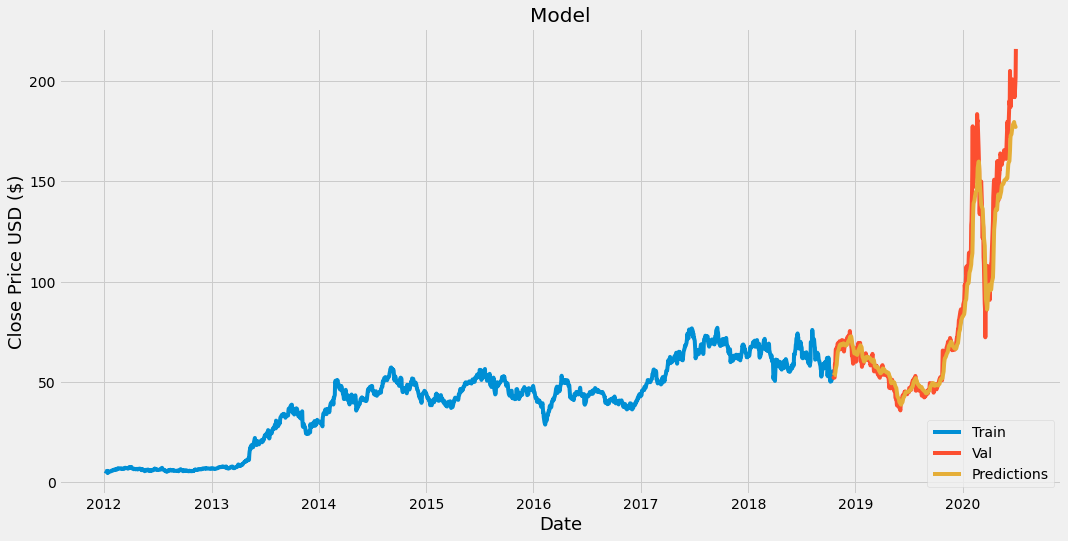

In [16]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [17]:
model.save('Model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Model/assets
